In [3]:
import astroquery
import numpy as np
import matplotlib.pyplot as plt
import pickle


In [2]:
def clean_lightcurve(data):
    """
    Expects data to be the unpickled dictionary from DataFetching
    """
    flux = data["flux"]
    flux_err = data["flux_err"]
    time = data["time"]

    if flux.mask is None:
        flux_arr = np.array(flux)
        flux_err_arr = np.array(flux_err)
        valid_mask = np.ones_like(flux_arr, dtype=bool)
    else:
        flux_arr = flux.filled(np.nan)
        flux_err_arr = flux_err.filled(np.nan)
        valid_mask = ~flux.mask

    return time[valid_mask], flux_arr[valid_mask], flux_err_arr[valid_mask]


In [5]:
with open("./DataFetching/confirmed_curves/confirmed_10601284.pkl", 'rb') as f:
    data_ex = pickle.load(f)

In [6]:
time_clean, flux_clean, flux_err_clean = clean_lightcurve(data_ex)

In [10]:
import pandas as pd

koi_df = pd.read_csv("DataFetching/KeplerObjectsOfInterest.csv", comment="#")

# Show which columns are available
print(koi_df.columns.tolist()[:20])  # see first 20 column names


['kepid', 'kepoi_name', 'kepler_name', 'koi_disposition', 'koi_pdisposition', 'koi_score', 'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec', 'koi_period', 'koi_period_err1', 'koi_period_err2', 'koi_time0bk', 'koi_time0bk_err1', 'koi_time0bk_err2', 'koi_impact', 'koi_impact_err1', 'koi_impact_err2', 'koi_duration']


In [11]:
planet_names = data_ex["planets"]
planet_info = koi_df[koi_df["kepler_name"].isin(planet_names)][
    ["kepler_name", "kepid", "koi_period", "koi_time0bk", "koi_duration"]
]
print(planet_info)


     kepler_name     kepid  koi_period  koi_time0bk  koi_duration
21  Kepler-226 c  10601284    5.349554    171.80694        3.0278
22  Kepler-226 b  10601284    3.941052    136.08662        2.5984
23  Kepler-226 d  10601284    8.109048    132.80310        3.5960


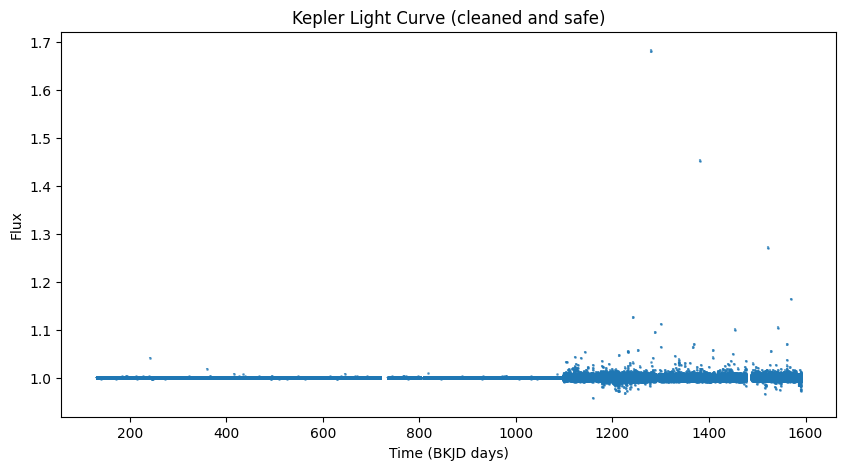

In [13]:
plt.figure(figsize=(10,5))
plt.errorbar(time_clean, flux_clean, yerr=flux_err_clean, fmt='.', ms=2, alpha=0.6)
plt.xlabel("Time (BKJD days)")
plt.ylabel("Flux")
plt.title("Kepler Light Curve (cleaned and safe)")
plt.show()

In [ ]:
for _, row in planet_info.iterrows():
    name = row["kepler_name"]
    period = row["koi_period"]
    t0 = row["koi_time0bk"]
    duration = row["koi_duration"] / 24.0  # convert hours → days

    # Predicted transit centers
    transit_times = np.arange(t0, time_clean.max(), period)

    for t_center in transit_times:
        # mask = (time_clean > t_center - 3*duration) & (time_clean < t_center + 3*duration)
        mask = (time_clean > t_center - 5) & (time_clean < t_center + 5)
        if np.any(mask):
            plt.figure(figsize=(8,4))
            plt.plot(time_clean[mask], flux_clean[mask], 'k.', ms=2)
            plt.axvline(t_center, color='red', linestyle='--')
            plt.title(f"{name} — Predicted transit @ {t_center:.2f}")
            plt.xlabel("Time [BJD - 2454833]")
            plt.ylabel("Flux")
            plt.show()


In [16]:
import lightkurve as lk

/Users/swebber/pythonvenvs/quantumcomet/lib/python3.10/site-packages/lightkurve/prf/__init__.py:7: UserWarning: Warning: the tpfmodel submodule is not available without oktopus installed, which requires a current version of autograd. See #1452 for details.
  warnings.warn(


In [17]:
import lightkurve as lk
import numpy as np

# Suppose you have your saved data
time = data_ex['time']
flux = data_ex['flux']
flux_err = data_ex['flux_err']

# Reconstruct LightCurve
lc = lk.LightCurve(time=time, flux=flux, flux_err=flux_err)

# Optional: remove NaNs
lc = lc.remove_nans()

In [21]:
lc_flat = lc.flatten(window_length=401)

In [22]:
import numpy as np
import lightkurve as lk

def generate_astronet_views(data_ex, period, t0, duration, 
                            global_bins=2001, local_bins=201, local_window_dur=5.0):
    """
    Generate AstroNet-style global and local views from saved light curve arrays.
    
    Parameters
    ----------
    data_ex : dict
        Pickle-loaded dictionary with keys: 'time', 'flux', 'flux_err', 'planets'
    period : float
        Orbital period of the planet in days
    t0 : float
        Reference mid-transit time (epoch) in days (BJD - 2454833)
    duration : float
        Transit duration in hours
    global_bins : int
        Number of bins for the global view (folded light curve)
    local_bins : int
        Number of bins for the local view (zoom around transit)
    local_window_dur : float
        Number of transit durations to include on each side for local view
    
    Returns
    -------
    global_phase : np.ndarray
        Phase array for global view (-0.5 to +0.5)
    global_flux : np.ndarray
        Binned flux for global view
    local_phase : np.ndarray
        Phase array for local view (centered on transit)
    local_flux : np.ndarray
        Binned flux for local view
    """
    
    # Extract arrays
    time = np.array(data_ex["time"])
    flux = np.array(data_ex["flux"])
    
    # Handle masked arrays
    if hasattr(flux, 'mask'):
        mask = np.zeros(flux.shape, dtype=bool) if flux.mask is None else flux.mask
        valid = ~mask
        time = time[valid]
        flux = flux[valid]
    else:
        valid = ~np.isnan(flux)
        time = time[valid]
        flux = flux[valid]
    
    # Reconstruct LightCurve object
    lc = lk.LightCurve(time=time, flux=flux)
    
    # --- GLOBAL VIEW ---
    lc_flat = lc.flatten(window_length=401)  # removes long-term trends
    lc_folded = lc_flat.fold(period=period, t0=t0)
    lc_global_binned = lc_folded.bin(bins=global_bins)
    
    global_phase = lc_global_binned.phase.value
    global_flux = lc_global_binned.flux.value
    
    # --- LOCAL VIEW ---
    # Pick the first transit in the LC
    transit_center = t0
    window_days = local_window_dur * duration / 24.0  # convert hours to days
    mask_local = (time > transit_center - window_days) & (time < transit_center + window_days)
    
    if np.sum(mask_local) == 0:
        raise ValueError("No data in local window. Try increasing local_window_dur.")
    
    lc_local = lk.LightCurve(time=time[mask_local], flux=flux[mask_local])
    lc_local_flat = lc_local.flatten(window_length=41)  # smaller window
    # fold locally on period relative to t0
    lc_local_folded = lc_local_flat.fold(period=period, t0=t0)
    lc_local_binned = lc_local_folded.bin(bins=local_bins)
    
    local_phase = lc_local_binned.phase.value
    local_flux = lc_local_binned.flux.value
    
    return global_phase, global_flux, local_phase, local_flux


In [24]:
# Single Example
planet_name = data_ex['planets'][0]
planet_info = koi_df[koi_df["kepler_name"] == planet_name][
    ["kepler_name", "kepid", "koi_period", "koi_time0bk", "koi_duration"]
]


In [25]:
name = planet_info["kepler_name"]
period = planet_info["koi_period"]
t0 = planet_info["koi_time0bk"]
duration = planet_info["koi_duration"] / 24.0  # convert hours → days

In [34]:
print(duration.iloc[0])

0.12615833333333334


In [35]:
global_phase, global_flux, local_phase, local_flux = generate_astronet_views(data_ex, period.iloc[0], t0.iloc[0], duration.iloc[0])

/Users/swebber/pythonvenvs/quantumcomet/lib/python3.10/site-packages/astropy/utils/decorators.py:603: LightkurveDeprecationWarning: "t0" was deprecated in version 2.0 and will be removed in a future version. Use argument "epoch_time" instead.
  return function(*args, **kwargs)
/Users/swebber/pythonvenvs/quantumcomet/lib/python3.10/site-packages/astropy/utils/decorators.py:603: LightkurveDeprecationWarning: "t0" was deprecated in version 2.0 and will be removed in a future version. Use argument "epoch_time" instead.
  return function(*args, **kwargs)


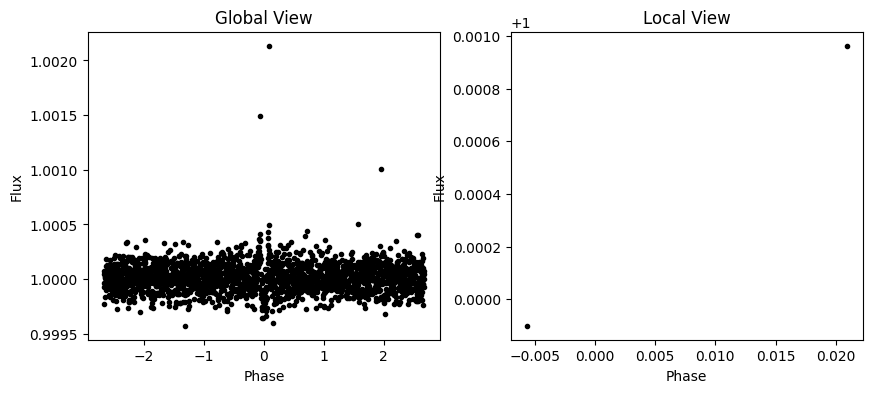

In [36]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(global_phase, global_flux, 'k.')
plt.title("Global View")
plt.xlabel("Phase")
plt.ylabel("Flux")

plt.subplot(1,2,2)
plt.plot(local_phase, local_flux, 'k.')
plt.title("Local View")
plt.xlabel("Phase")
plt.ylabel("Flux")
plt.show()